In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import time

In [2]:
class generator(tf.keras.Model):
    def __init__(self):
        super(generator,self).__init__()
        
        self.dense1 = tf.keras.layers.Dense(7*7*256,input_dim=(100,))
        self.reshape = tf.keras.layers.Reshape((7,7,256))
        
        self.conv1 = tf.keras.layers.Conv2DTranspose(128,kernel_size=5,strides=1,padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = tf.keras.layers.Conv2DTranspose(64,kernel_size=5,strides=2,padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.conv3 = tf.keras.layers.Conv2DTranspose(1,kernel_size=5,strides=2,padding='same')
        
    def call(self,input_tensor,training=False):
        x = self.dense1(input_tensor)
        x = self.reshape(x)
        
        x = self.conv1(x)
        x = self.bn1(x, training = training)
        x = tf.nn.leaky_relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x, training = training)
        x = tf.nn.leaky_relu(x)
        
        x = self.conv3(x)
        x = tf.nn.tanh(x)
        return x

In [3]:
class discriminator(tf.keras.Model):
    def __init__(self):
        super(discriminator,self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32,kernel_size=3,strides=2,padding='same')        
        self.conv2 = tf.keras.layers.Conv2D(64,kernel_size=3,strides=2,padding='same')
        self.conv3 = tf.keras.layers.Conv2D(128,kernel_size=3,strides=2,padding='same')
        self.global_avg = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(1)
        
    def call(self,input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = tf.nn.leaky_relu(x,alpha=0.2)

        x = self.conv2(x)
        x = tf.nn.leaky_relu(x,alpha=0.2)

        x = self.conv3(x)
        x = tf.nn.leaky_relu(x,alpha=0.2)
        
        x = self.global_avg(x)
        x = self.fc1(x)
        x = tf.nn.sigmoid(x)
 
        return x

In [4]:
d = discriminator()
g = generator()
generator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)


In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss * 0.5 + fake_loss * 0.5
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [6]:
(x_train,_),(_,_) = tf.keras.datasets.mnist.load_data()
x_train = x_train/127.5 -1
train_dataset = tf.data.Dataset.from_tensor_slices(x_train[...,tf.newaxis])
train_dataset
train_dataset = train_dataset.shuffle(50000).batch(256)

for epoch in range(50):
    start_time = time.time()
    for step, x_batch in enumerate(train_dataset):
        noise = tf.random.normal([64,100])
#         print(x_batch)
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_img = g(noise, training=True)
            
            real_output = d(x_batch, training=True)
            fake_output = d(generated_img, training=True)
            
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)
            
        gradients_of_generator = gen_tape.gradient(gen_loss, g.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, d.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, g.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, d.trainable_variables))
        if step % 100 == 0:
            print(f'epoch : {epoch} step : {step} gen_loss : {gen_loss} disc_loss : {disc_loss}')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch : 0 step : 0 gen_loss : 0.4728084206581116 disc_loss : 0.7230579853057861
epoch : 0 step : 100 gen_loss : 0.5254334211349487 disc_loss : 0.6499189138412476
epoch : 0 step : 200 gen_loss : 0.5510447025299072 disc_loss : 0.6680651307106018
epoch : 1 step : 0 gen_loss : 0.5474011301994324 disc_loss : 0.6572705507278442
epoch : 1 step : 100 gen_loss : 0.6931470632553101 disc_loss : 0.6931470632553101
epoch : 1 step : 200 gen_loss : 0.6931470632553101 disc_loss : 0.6931470632553101
epoch : 2 step : 0 g

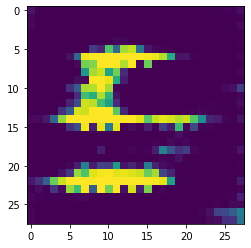

In [25]:
img=g(np.random.normal(0,1,(1,100)))
plt.imshow(((img+1)*127.5).numpy().astype(np.uint8)[0])